# setup

In [1]:
# Import packages
import re
import numpy as np
import pandas as pd
import csv
import json
import os
import random
import time
import tqdm
from collections import defaultdict

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

# spacy for lemmatization
import spacy

# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
path = '/Users/alexwey/Desktop/ipynb/'

In [4]:
# Import all json files
document_path = f'{path}documents/'
data = defaultdict(list)
c = 0
for filename in os.listdir(document_path):
  d = json.JSONDecoder()
  with open(document_path + filename, 'r') as file:
    for record in file:
      record_data = d.decode(record)
      source = record_data['domain'].split('.')[0]
      if source == 'reddit':
        human_text = record_data['text']
        grover_text = record_data['gens_article'][0]
        data[source].append((human_text, grover_text))

total = 0
for key, value in data.items():
  print(key, len(value))
  total += len(value)

print('total', total)

reddit 88
total 88


# preprocessing documents

In [5]:
# Remove emails, new lines, and single quotes
def preremoval(text):
  text = re.sub('\S*@\S*\s?', '', text)
  text = re.sub('\s+', ' ', text)
  text = re.sub("\'", "", text)
  return text

# Tokenize
def tokenize(text):
  return(gensim.utils.simple_preprocess(str(text), deacc=True)) # deacc=True removes punctuations

# Remove stopwords
def remove_stopwords(texts):
  return [(doc[0], doc[1], [word for word in simple_preprocess(str(doc[2])) if word not in stop_words]) for doc in texts]

# Make bigrams
def make_bigrams(nostops, tups):
  texts = [elem[2] for elem in tups]
  bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold, fewer phrases
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  return [(doc[0], doc[1], bigram_mod[doc[2]]) for doc in nostops]

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm")

# Lemmatize
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  lemmatized_out = []
  for sent in texts:
    doc = nlp(" ".join(sent[2]))
    lemmatized_out.append((sent[0], sent[1], [token.lemma_ for token in doc if token.pos_ in allowed_postags]))

  return lemmatized_out

# Preprocess set of texts
def preprocess(texts):
  nostops = remove_stopwords(texts)
  bigrams = make_bigrams(nostops, texts)
  lemmatized_out = lemmatization(bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
  return lemmatized_out

In [ ]:
# Collect dataset
all_texts = []
tokenized = []
for source, docs in data.items():
  for tup in docs:
    human_words = tokenize(preremoval(tup[0]))
    grover_words = tokenize(preremoval(tup[1]))
    tokenized.append((source, 'h', human_words))
    tokenized.append((source, 'g', grover_words))
    all_texts.append((source, tup[0], tup[1]))

# Preprocess data
preprocessed_data = preprocess(tokenized)

# Aggregate data accordingly
all_data = []
reddit_human_data = []
reddit_grover_data = []

for doc in preprocessed_data:
  all_data.append(doc[2])

  if doc[0] == 'reddit':
    if doc[1] == 'h':
      reddit_human_data.append(doc[2])
    else:
      reddit_grover_data.append(doc[2])

print(all_data[:2])
print(all_texts[:2])

In [7]:
# Calculate average lengths of prompts/generations for normalization
reddit_prompt_avg_len, reddit_generation_avg_len, reddit_c = 0, 0, 0
reddit_prompt_min, reddit_prompt_max = float('inf'), 0
reddit_generation_min, reddit_generation_max = float('inf'), 0


for source, texts in data.items():
  if source == 'reddit':
    for pairs in texts:
      reddit_c += 1
      prompt_len = len(pairs[0].split())
      generation_len = len(pairs[1].split())
      reddit_prompt_avg_len += prompt_len
      reddit_generation_avg_len += generation_len
      if prompt_len < reddit_prompt_min:
        reddit_prompt_min = prompt_len
      if generation_len < reddit_generation_min:
        reddit_generation_min = generation_len
      if prompt_len > reddit_prompt_max:
        reddit_prompt_max = prompt_len
      if generation_len > reddit_generation_max:
        reddit_generation_max = generation_len

reddit_prompt_avg_len /= reddit_c
reddit_generation_avg_len /= reddit_c

print("Reddit Prompt Avg Length: ", reddit_prompt_avg_len)
print("Reddit Generation Avg Length: ", reddit_generation_avg_len)
print("Reddit Prompt Min: ", reddit_prompt_min)
print("Reddit Prompt Max: ", reddit_prompt_max)
print("Reddit Generation Min: ", reddit_generation_min)
print("Reddit Generation Max: ", reddit_generation_max)

Reddit Prompt Avg Length:  282.96590909090907
Reddit Generation Avg Length:  536.4772727272727
Reddit Prompt Min:  201
Reddit Prompt Max:  399
Reddit Generation Min:  151
Reddit Generation Max:  808


# run model

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(all_data)

# Create Corpus
texts = all_data

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Initialize num_topics
num_topics = 50

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           eta='auto',
                                           per_word_topics=True)

# load LDA model

In [9]:
# Load id2word
pretrained_id2word = gensim.corpora.Dictionary.load(f'{path}pretrained_models/reddit/RC_LDA_50_True.lda.id2word')

# Load pretrained LDA model
pretrained_lda_model = gensim.models.ldamodel.LdaModel.load(f'{path}pretrained_models/reddit/RC_LDA_50_True.lda')

# coherence values

In [10]:
# Obtain coherence model
cm = CoherenceModel(model=pretrained_lda_model, texts=all_data, corpus=corpus, dictionary=pretrained_id2word, coherence='u_mass')

# Obtain segmented topics
segmented_topics = cm.segment_topics()

# Calculate topic specific coherence values
coherence_values = cm.get_coherence_per_topic(segmented_topics)

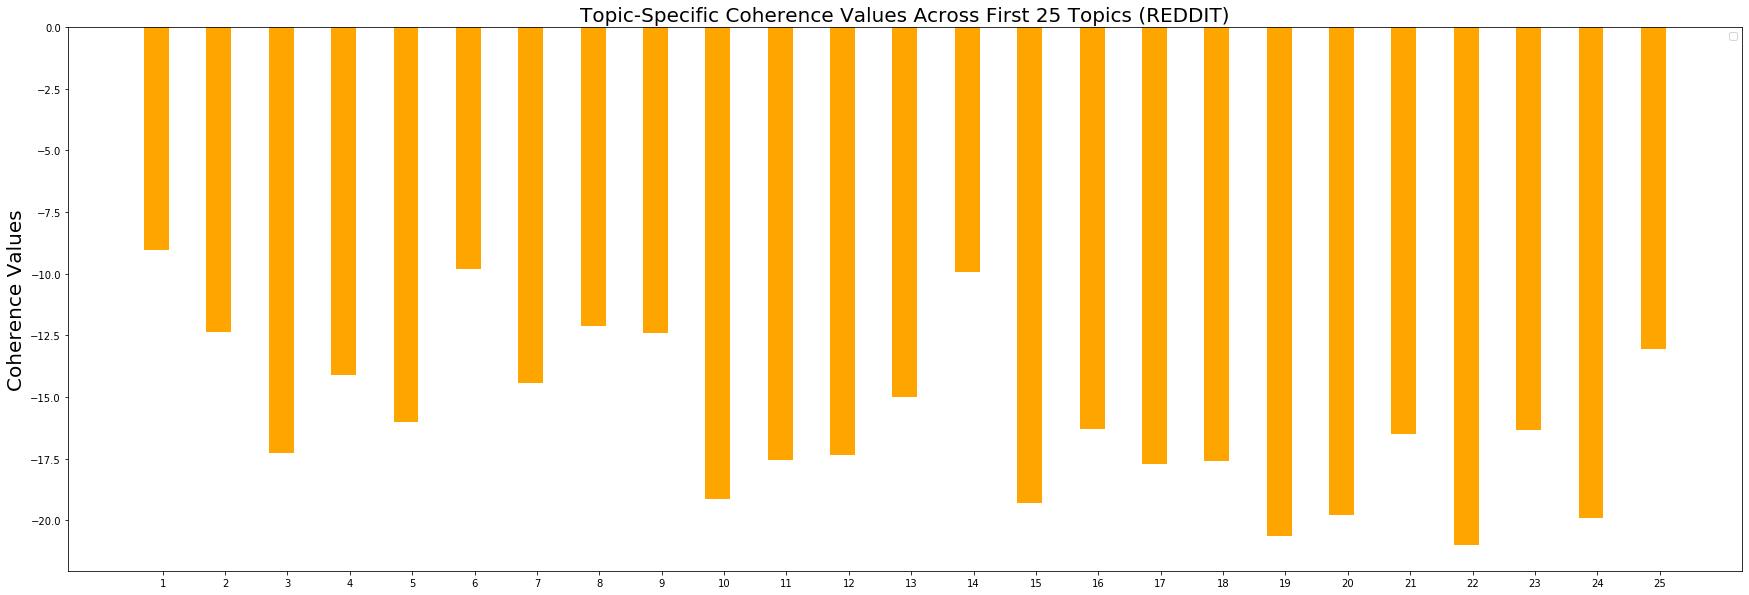

In [11]:
# Configure specifications for bar plot
X = np.arange(1, 26)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, coherence_values[:25], color='orange', width=0.4)

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Coherence Values', fontsize=20)
ax.set_title('Topic-Specific Coherence Values Across First 25 Topics (REDDIT)', fontsize=20)
ax.set_xticks(X)
ax.legend()

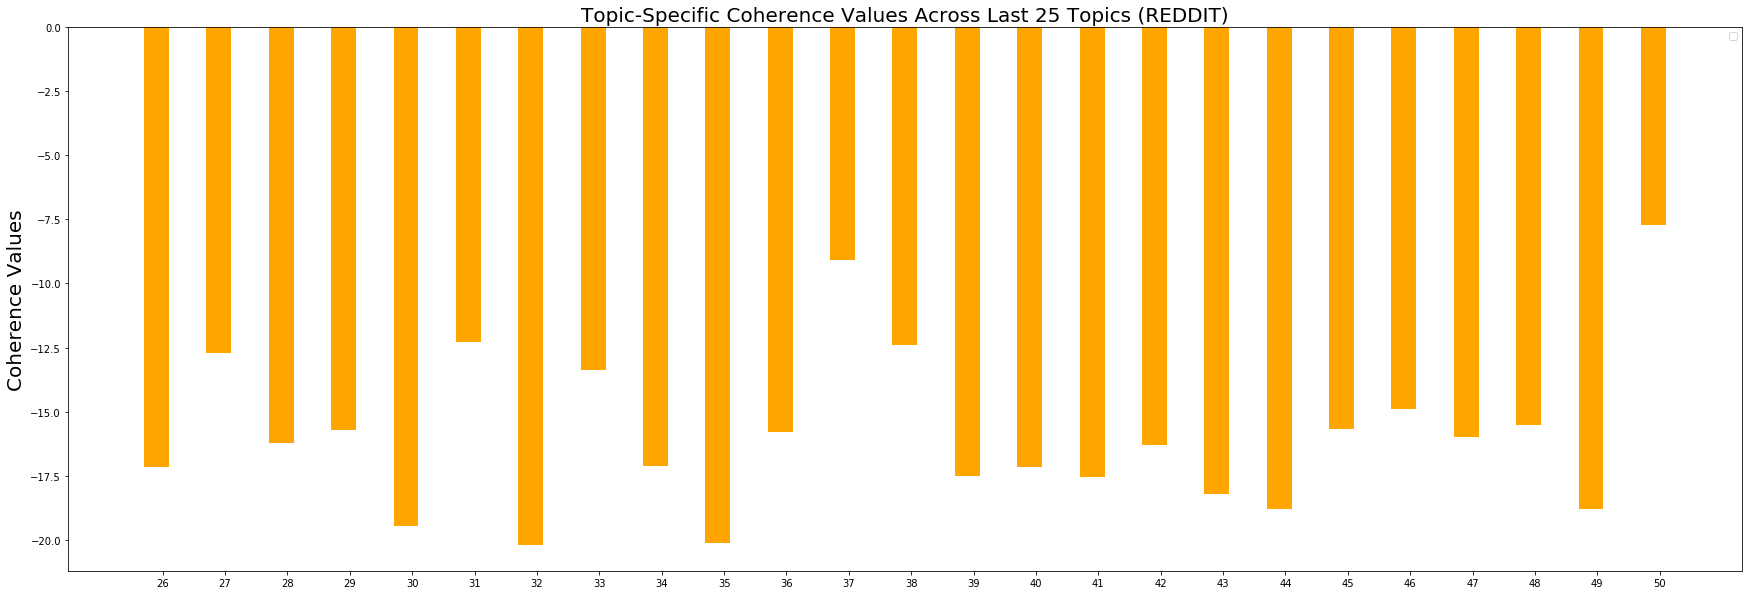

In [12]:
# Configure specifications for bar plot
X = np.arange(26, 51)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, coherence_values[25:], color='orange', width=0.4)

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Coherence Values', fontsize=20)
ax.set_title('Topic-Specific Coherence Values Across Last 25 Topics (REDDIT)', fontsize=20)
ax.set_xticks(X)
ax.legend()

# topic distribution preprocessing



In [34]:
# Convert documents to BoW format
def convert_to_bow(words_set):
  bows = []
  for words in words_set:
    bow = pretrained_id2word.doc2bow(words)
    bows.append(bow)
  return bows

# Obtain topic distribution for all documents
def get_topic_dist(documents, pwt):
  outputs = []
  for document in documents:
    if pwt:
      output = pretrained_lda_model.get_document_topics(document, per_word_topics=True)
      outputs.append(output)
    else:
      output = pretrained_lda_model.get_document_topics(document)
      outputs.append(output)
  return outputs

In [14]:
# Convert data to BoW
reddit_human_bow = convert_to_bow(reddit_human_data)
reddit_grover_bow = convert_to_bow(reddit_grover_data)

# Obtain distribution (pwt = False)
reddit_human_dist = get_topic_dist(reddit_human_bow, False)
reddit_grover_dist = get_topic_dist(reddit_grover_bow, False)

# Make a copy
reddit_human_dist_copy = reddit_human_dist
reddit_grover_dist_copy = reddit_grover_dist

# average word counts across topics

In [15]:
# Get the number of words contributed by topics
def calc_words(dist, dist_pwt):
  for i in range(len(dist)):
    word_count = get_word_count(dist_pwt[i][1])
    for j in range(len(dist[i])):
      topic_id = dist[i][j][0]
      contribution = dist[i][j][1]
      dist[i][j] = (topic_id, contribution * word_count)

def get_word_count(output):
    count = 0
    for tup in output:
        if len(tup[1]) > 0:
            count += 1
    return count

# Normalize word contributions (try this with z-score approach, subtract mean and divide by std dev)
def normalize_wc(dist):
    x_mean, doc_count = 0, 0
    tups = [tup for doc_dist in dist for tup in doc_dist]
    wc_list = []
    for tup in tups:
        wc = tup[1]
        x_mean += wc
        doc_count += 1
        wc_list.append(wc)

    x_mean /= doc_count
    x_std = np.std(np.array(wc_list))
    
    for i in range(len(dist)):
        for j in range(len(dist[i])):
          topic_id = dist[i][j][0]
          wc_not_norm = dist[i][j][1]
          wc_norm = (wc_not_norm - x_mean) / x_std
          dist[i][j] = (topic_id, wc_norm)
            

#   x_min, x_max = float('inf'), 0
#   tups = [tup for doc_dist in dist for tup in doc_dist]
#   for tup in tups:
#     wc = tup[1]
#     if wc < x_min:
#       x_min = wc
#     if wc > x_max:
#       x_max = wc

#   for i in range(len(dist)):
#     for j in range(len(dist[i])):
#       topic_id = dist[i][j][0]
#       wc_not_norm = dist[i][j][1]
#       wc_norm = (wc_not_norm - x_min) / (x_max - x_min)
#       dist[i][j] = (topic_id, wc_norm)
    

# Get averages after normalizing data
def average(dist):
  tups = [tup for doc_dist in dist for tup in doc_dist]
  sums = [0] * num_topics
  counts = [0] * num_topics
  for tup in tups:
    idx = tup[0]
    sums[idx] += tup[1]
    counts[idx] += 1
  avg_data = [sum / count for sum, count in zip(sums, counts)] 
  return avg_data

In [16]:
# Obtain distribution (pwt = True)
reddit_human_dist_pwt = get_topic_dist(reddit_human_bow, True)
reddit_grover_dist_pwt = get_topic_dist(reddit_grover_bow, True)

# Calculate number of words per document
calc_words(reddit_human_dist, reddit_human_dist_pwt)
calc_words(reddit_grover_dist, reddit_grover_dist_pwt)

# Normalize word conributions
normalize_wc(reddit_human_dist)
normalize_wc(reddit_grover_dist)

# Calculate average number of words
reddit_human_avg = average(reddit_human_dist)
reddit_grover_avg = average(reddit_grover_dist)

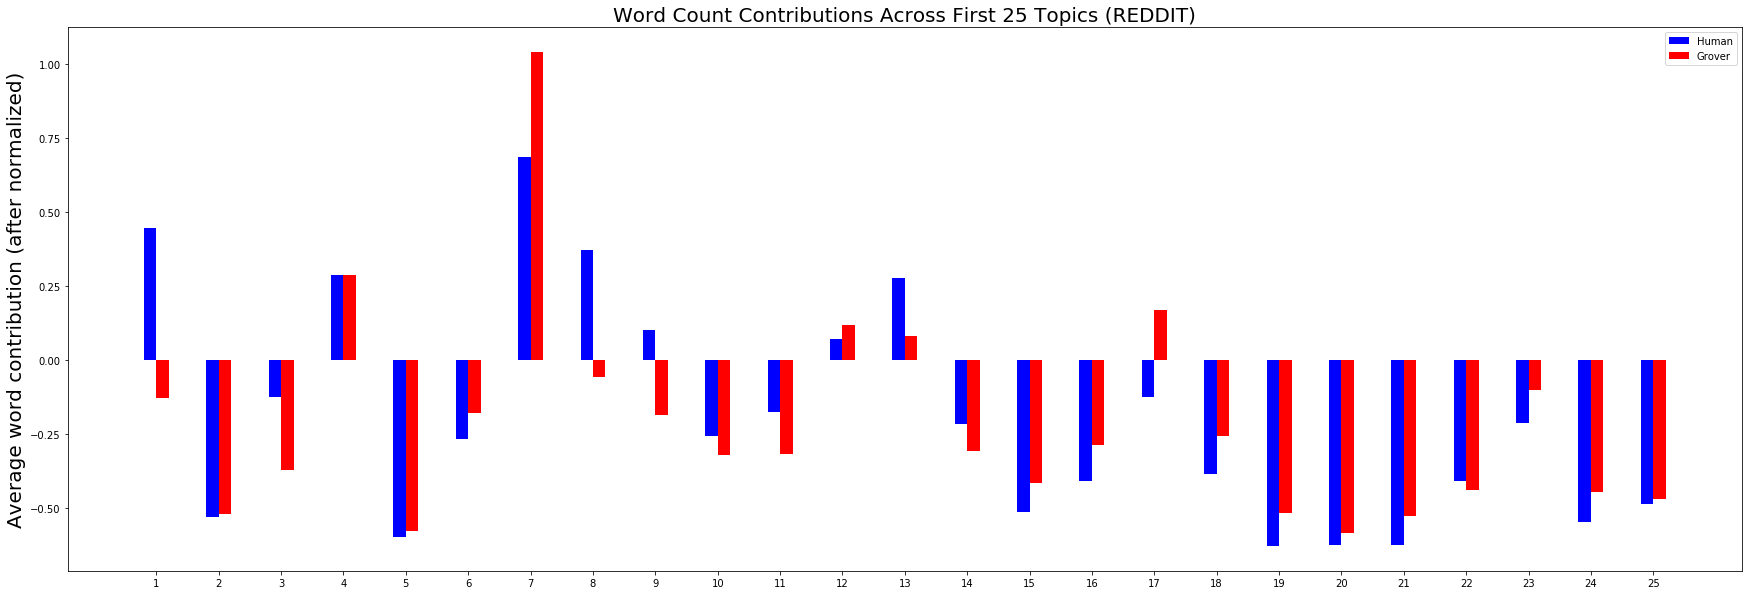

In [17]:
# Configure specifications for bar plot (REDDIT)
X = np.arange(1, 26)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, reddit_human_avg[:25], color='b', width=0.2, label='Human')
ax.bar(X + 0.1, reddit_grover_avg[:25], color = 'r', width=0.2, label='Grover')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Average word contribution (after normalized)', fontsize=20)
ax.set_title('Word Count Contributions Across First 25 Topics (REDDIT)', fontsize=20)
ax.set_xticks(X)
ax.legend()

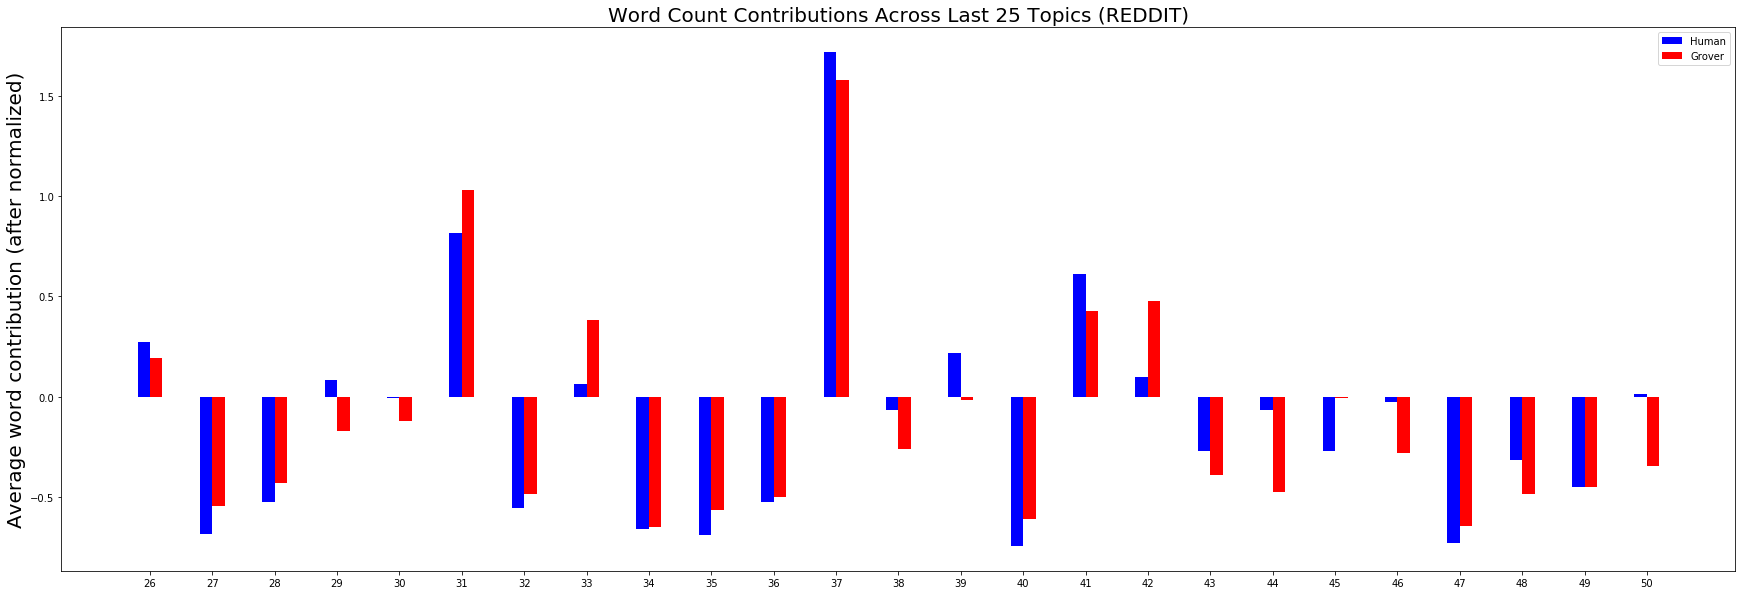

In [18]:
# Configure specifications for bar plot (REDDIT)
X = np.arange(26, 51)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, reddit_human_avg[25:], color='b', width=0.2, label='Human')
ax.bar(X + 0.1, reddit_grover_avg[25:], color = 'r', width=0.2, label='Grover')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Average word contribution (after normalized)', fontsize=20)
ax.set_title('Word Count Contributions Across Last 25 Topics (REDDIT)', fontsize=20)
ax.set_xticks(X)
ax.legend()

# difference in average word counts across topics

In [19]:
# Calculates difference in distributions
def calc_difs(human, grover):
  res = []
  for i in range(len(human)):
    human_dist_dic = dict(human[i])
    grover_dist_dic = dict(grover[i])

    for key in human_dist_dic.keys():
      if key not in grover_dist_dic.keys():
        grover_dist_dic[key] = 0
    for key in grover_dist_dic.keys():
      if key not in human_dist_dic.keys():
        human_dist_dic[key] = 0
    
    difs_dic = {}
    for key, val in human_dist_dic.items():
      difs_dic[key] = human_dist_dic[key] - grover_dist_dic[key]
    difs_tups = [(k, v) for k, v in difs_dic.items()]
    res.append(difs_tups)
      
  return res

In [20]:
# Calculate differences in topic contributions
reddit_difs = calc_difs(reddit_human_dist, reddit_grover_dist)

# Calculate average of differences
reddit_difs_avg = average(reddit_difs)

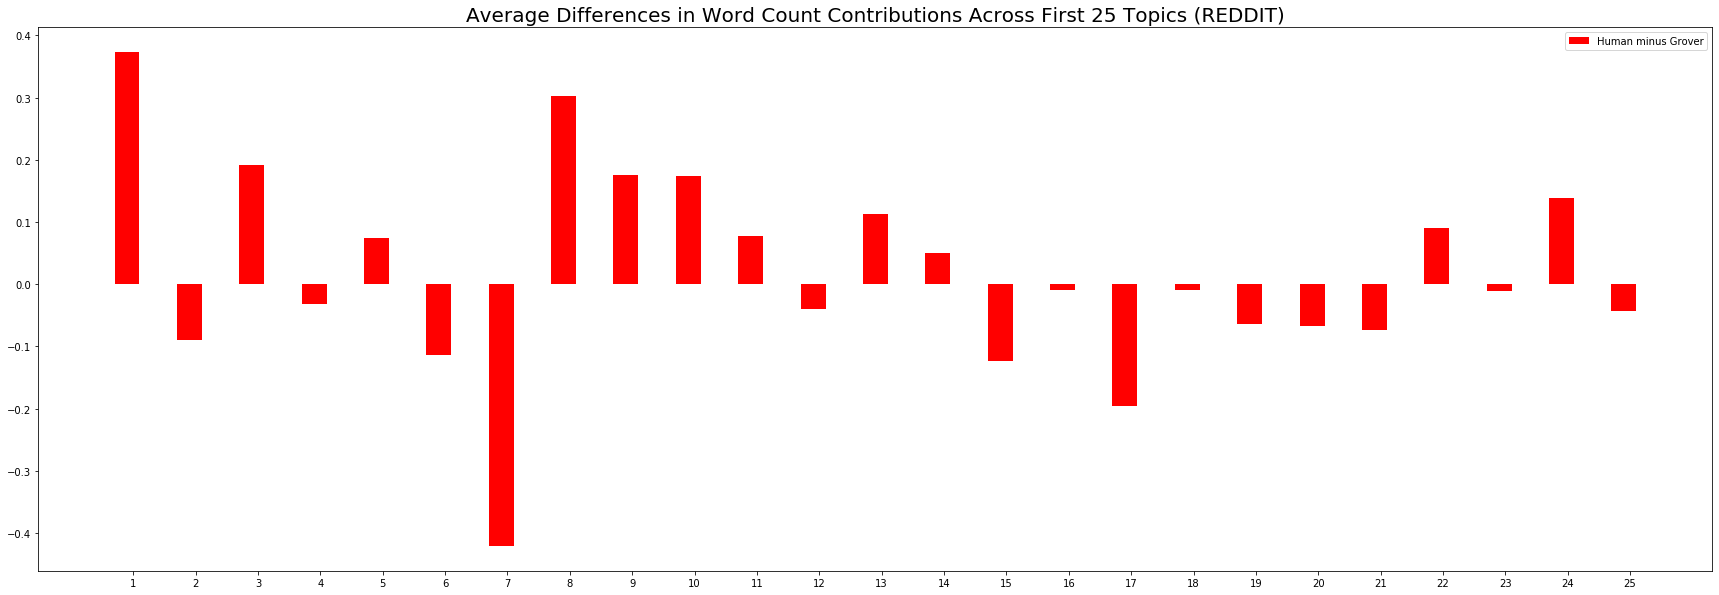

In [21]:
# Configure specifications for bar plot (REDDIT)
X = np.arange(1, 26)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, reddit_difs_avg[:25], color='r', width=0.4, label='Human minus Grover')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('', fontsize=20) # average number of words per topic instead
ax.set_title('Average Differences in Word Count Contributions Across First 25 Topics (REDDIT)', fontsize=20)
ax.set_xticks(X)
ax.legend()

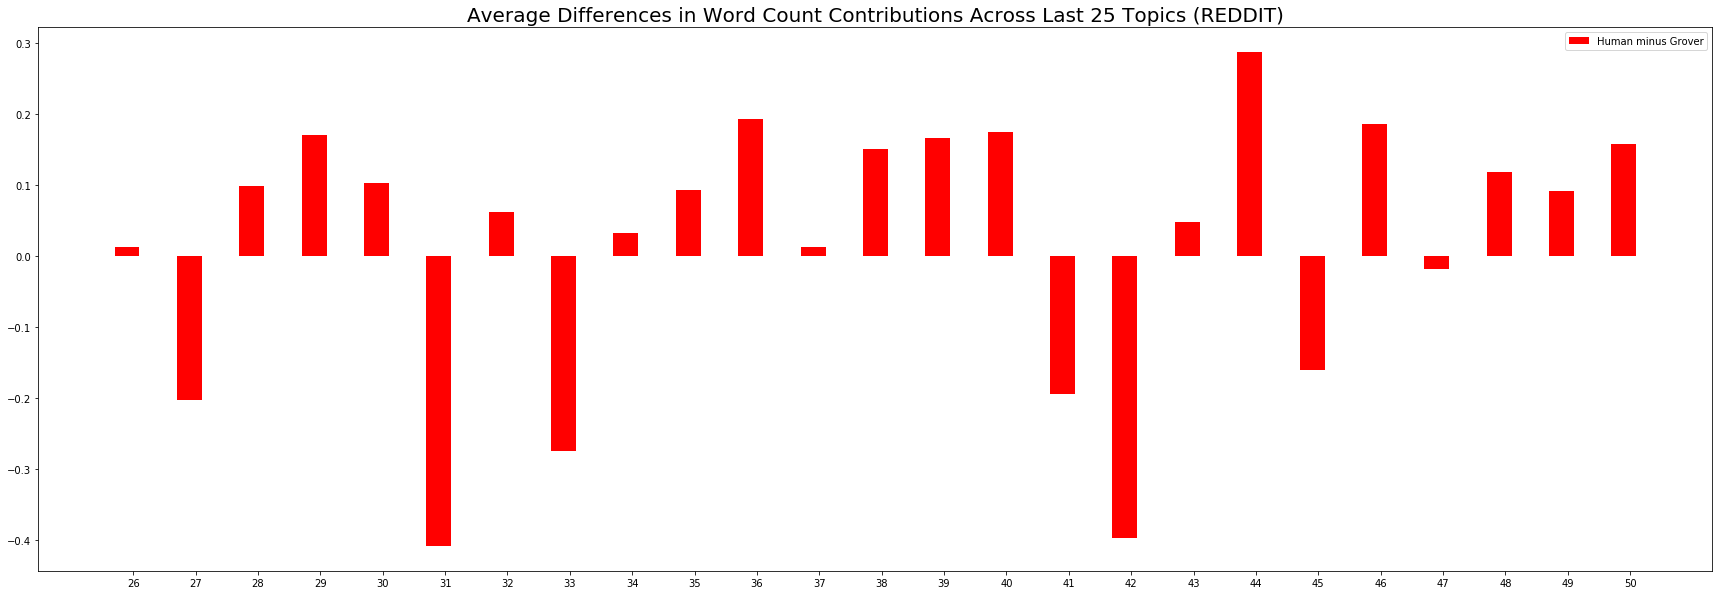

In [22]:
# Configure specifications for bar plot (REDDIT)
X = np.arange(26, 51)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, reddit_difs_avg[25:], color='r', width=0.4, label='Human minus Grover')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('', fontsize=20) # average number of words per topic instead
ax.set_title('Average Differences in Word Count Contributions Across Last 25 Topics (REDDIT)', fontsize=20)
ax.set_xticks(X)
ax.legend()

# documents higher than 50% more than uniform distribution

In [23]:
# Count number of documents 50% higher than uniform distribution
def count_high_threshold(dist):
  threshold = 1.5/num_topics
  count = [0] * num_topics
  for doc in dist:
    for tup in doc:
      if tup[1] > threshold:
        count[tup[0]] += 1
  return count

In [24]:
# Count number of documents higher than 50% threshold
reddit_human_higher = count_high_threshold(reddit_human_dist_copy)
reddit_grover_higher = count_high_threshold(reddit_grover_dist_copy)

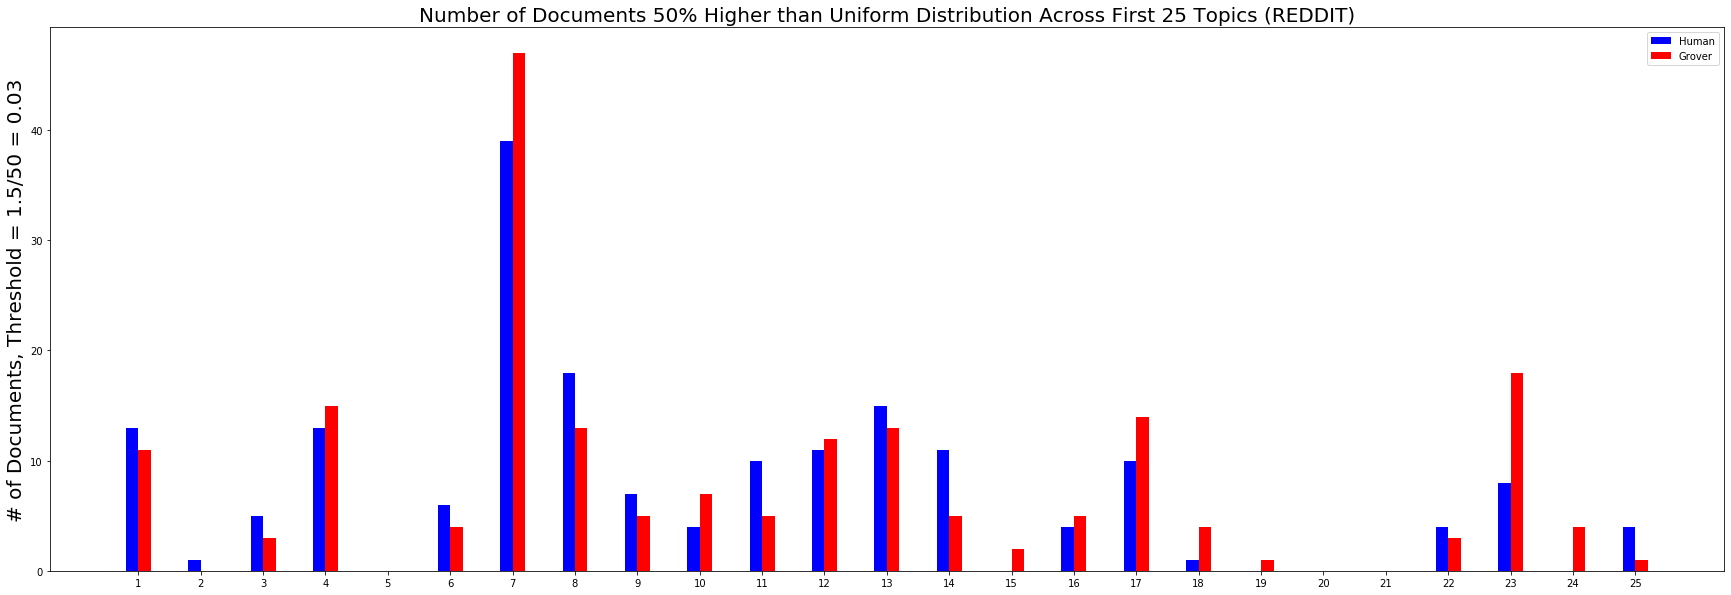

In [25]:
# Configure specifications for bar plot (REDDIT)
X = np.arange(1, 26)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, reddit_human_higher[:25], color='b', width=0.2, label='Human')
ax.bar(X + 0.1, reddit_grover_higher[:25], color = 'r', width=0.2, label='Grover')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('# of Documents, Threshold = 1.5/50 = 0.03', fontsize=20)
ax.set_title('Number of Documents 50% Higher than Uniform Distribution Across First 25 Topics (REDDIT)', fontsize=20)
ax.set_xticks(X)
ax.legend()

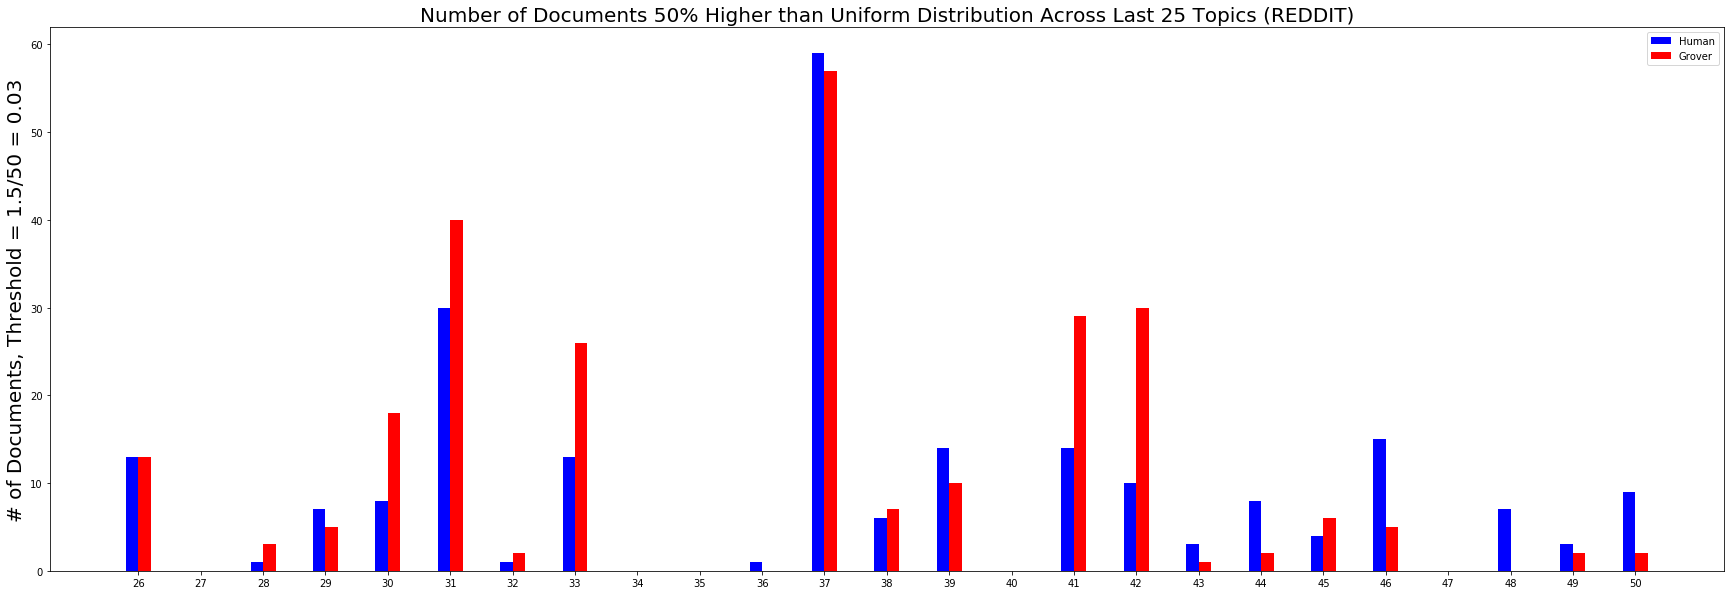

In [26]:
# Configure specifications for bar plot (REDDIT)
X = np.arange(26, 51)
fig, ax = plt.subplots(figsize=(30,10))
ax.bar(X - 0.1, reddit_human_higher[25:], color='b', width=0.2, label='Human')
ax.bar(X + 0.1, reddit_grover_higher[25:], color = 'r', width=0.2, label='Grover')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('# of Documents, Threshold = 1.5/50 = 0.03', fontsize=20)
ax.set_title('Number of Documents 50% Higher than Uniform Distribution Across Last 25 Topics (REDDIT)', fontsize=20)
ax.set_xticks(X)
ax.legend()

# single-most/least representative documents

In [27]:
# Get texts for Reddit/News
reddit_texts = [text for text in all_texts if text[0] == 'reddit']

In [28]:
# Document that is single-most/least representative of differences in topic contributions
def most_representative(difs):
  human_most, human_idx = (-1, 0), -1
  grover_most, grover_idx = (-1, 0), -1
  for i, doc in enumerate(difs):
    for tup in doc:
      if tup[1] > human_most[1]:
        human_most = tup
        human_idx = i
      if tup[1] < grover_most[1]:
        grover_most = tup
        grover_idx = i
  
  return human_idx, grover_idx, human_most, grover_most

def least_representative(difs):
  human_least, human_idx = (-1, float('inf')), -1
  grover_least, grover_idx = (-1, float('-inf')), -1
  for i, doc in enumerate(difs):
    for tup in doc:
      if tup[1] < human_least[1] and tup[1] > 0:
        human_least = tup
        human_idx = i
      if tup[1] > grover_least[1] and tup[1] < 0:
        grover_least = tup
        grover_idx = i
    
  return human_idx, grover_idx, human_least, grover_least

def find_print_results(most, human_idx, grover_idx, human_res, grover_res, all, reddit, news):
  if all:
    human_rep = all_texts[human_idx]
    grover_rep = all_texts[grover_idx]
  if reddit:
    human_rep = reddit_texts[human_idx]
    grover_rep = reddit_texts[grover_idx]
  if news:
    human_rep = news_texts[human_idx]
    grover_rep = news_texts[grover_idx]

  if most:
    print('Most Representative Human Document:')
  else:
    print('Least Representative Human Document:')
  print(human_res, human_idx)
  print('SOURCE:', human_rep[0])
  print('HUMAN:', human_rep[1])
  print('GROVER:', human_rep[2])

  if most:
    print('Most Representative Grover Document:')
  else:
    print('Least Representative Grover Document:')
  print(grover_res, grover_idx)
  print('SOURCE:', grover_rep[0])
  print('HUMAN:', grover_rep[1])
  print('GROVER:', grover_rep[2])

In [29]:
reddit_hidx, reddit_gidx, human_res, grover_res = most_representative(reddit_difs)
find_print_results(True, reddit_hidx, reddit_gidx, human_res, grover_res, False, True, False)
reddit_hidx, reddit_gidx, human_res, grover_res = least_representative(reddit_difs)
find_print_results(False, reddit_hidx, reddit_gidx, human_res, grover_res, False, True, False)

Most Representative Human Document:
(30, 6.5129379323911625) 31
SOURCE: reddit
HUMAN: Thanks for the love! Same to you! I'm not totally sure what the laws are like in Beirut, but I willtell you what it would be like if you were coming to Saudi. First of all, as a girl, it would be next to impossible for you to find weed. Hash would be more likely but even then, extremely rare. In Saudi Arabia it's so illegal you could get your head cut off for the right amount. Especially if you area foreigner they might suspect you of smuggling. Keep in mind that here, most women are supposed to see their lives as a priviledge afforded to them by men, (which in a lot of situations, is financially the case) You might get lucky here and there, but most likely from some dude who wants to get into your pants. Chances are you are better of just giving it a rest for a while- I had to and it went better than expected. I dont fiend or suffer from cravings since I know it's just impossible to get at the moment

# topic words analysis

In [30]:
# Obtain most probable words under each topic
def get_topic_words():
  res = {}
  for i in range(num_topics): # change depending on # topics
    print(f'Topic {i + 1}')
    top_idxs = pretrained_lda_model.get_topic_terms(i, topn=40) # increase depending on if sets have limited number of unique words
    top_words = [pretrained_id2word[word_id[0]] for word_id in top_idxs]
    print(top_words)
    res[f'Topic {i + 1}'] = top_words
  return res
  
topic_words = get_topic_words()

Topic 1
['alcohol', 'drink', 'marijuana', 'more', 'people', 'use', 'prohibition', 'age', 'effect', 'tobacco', 'beer', 'drug', 'cause', 'harmful', 'dangerous', 'can', 'consume', 'less', 'legal', 'brain', 'like', 'harm', 'much', 'substance', 'adult', 'safe', '21', 'bad', 'ban', 'cigarette', 'negative', 'consumption', 'should', 'booze', 'kill', 'death', 'regulate', 'also', 'teen', 'far']
Topic 2
['not', '-PRON-', 'do', 'should', 'weed', 'like', 'can', 'be', 'think', 'say', 'get', 'want', 'know', 'people', 'would', 'all', 'could', 'something', 'because', 'anything', 'go', 'yeah', 'really', 'thing', 'maybe', 'right', 'why', 'tell', 'need', 'even', 'how', 'mean', 'sure', 'ok', 'make', 'else', 'someone', 'let', 'anyone', 'care']
Topic 3
['grow', 'hemp', 'plant', 'cannabis', 'farm', 'seed', 'can', 'use', 'grower', 'produce', 'farmer', 'legal', 'production', 'crop', 'industrial', 'home', 'industry', 'product', 'paper', 'make', 'all', 'harvest', 'land', 'plastic', 'legally', 'cultivation', 'pest

['test', 'drug', 'x200b', 'article', 'positive', 'read', 'testing', 'fail', 'use', 'can', 'marijuana', 'google', 'any', 'say', 'show', 'result', 'blood', 'find', 'even', 'pass', 'link', 'field', 'system', 'week', 'random', 'still', 'urine', 'headline', 'take', 'claim', 'mention', 'since', 'could', 'also', 'false', 'policy', 'how', 'prove', 'proof', 'require']
Topic 37
['people', 'say', 'think', 'can', 'how', 'would', 'like', 'know', 'make', 'because', 'thing', 'all', 'point', 'one', 'see', 'any', 'more', 'way', 'may', 'even', 'someone', 'why', 'something', 'want', 'go', 'seem', 'try', 'should', 'issue', 'fact', 'talk', 'really', 'mean', 'good', 'person', 'well', 'also', 'use', 'understand', 'question']
Topic 38
['get', 'jail', 'charge', 'possession', 'prison', 'arrest', 'catch', 'sentence', 'marijuana', 'time', 'felony', 'people', 'go', 'amount', 'fine', 'can', 'record', 'year', 'someone', 'even', 'probation', 'life', 'offense', 'sell', 'conviction', 'punishment', 'small', 'still', 'th

In [31]:
# Unique words algorithm
def word_count(t, w, topic_words):
  c = 0
  appears = "unique"
  for topic, words in topic_words.items():
    if t != topic:
      c += words.count(w)
      if words.count(w) != 0:
        appears = topic
  return c, appears

unique_topic_words = defaultdict(list)
for topic, words in topic_words.items():
  for word in words:
    c, appears = word_count(topic, word, topic_words)
    if c == 0 or c == 1:
      unique_topic_words[topic].append((word, appears))
  
for topic, words in unique_topic_words.items():
  print(topic)
  print(words)

Topic 1
[('alcohol', 'unique'), ('drink', 'unique'), ('prohibition', 'Topic 8'), ('age', 'Topic 23'), ('tobacco', 'Topic 46'), ('beer', 'unique'), ('harmful', 'unique'), ('dangerous', 'Topic 20'), ('consume', 'unique'), ('brain', 'unique'), ('harm', 'unique'), ('substance', 'Topic 20'), ('adult', 'Topic 23'), ('safe', 'Topic 13'), ('21', 'unique'), ('cigarette', 'Topic 46'), ('negative', 'unique'), ('consumption', 'unique'), ('booze', 'unique'), ('kill', 'Topic 49'), ('regulate', 'unique'), ('teen', 'unique'), ('far', 'Topic 28')]
Topic 2
[('not', 'unique'), ('do', 'unique'), ('be', 'unique'), ('anything', 'Topic 16'), ('maybe', 'unique'), ('ok', 'unique'), ('else', 'unique'), ('let', 'Topic 50'), ('anyone', 'unique')]
Topic 3
[('grow', 'unique'), ('hemp', 'unique'), ('plant', 'unique'), ('farm', 'unique'), ('seed', 'unique'), ('grower', 'unique'), ('produce', 'unique'), ('farmer', 'unique'), ('production', 'unique'), ('crop', 'unique'), ('industrial', 'unique'), ('industry', 'Topic 26

# visual analysis

In [ ]:
# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=pp_data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

# compute optimal number of topics

In [ ]:
def compute_coherence_values(corpus, id2word, k):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                          id2word=id2word,
                                          num_topics=k, 
                                          random_state=100,
                                          update_every=1,
                                          chunksize=100,
                                          passes=10,
                                          alpha='auto',
                                          eta='auto',
                                          per_word_topics=True)
  
  coherence_model_lda = CoherenceModel(model=lda_model, texts=pp_data, corpus=corpus, dictionary=id2word, coherence='c_v')
    
  return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
topics_range = range(2, 30, 1)

# Alpha parameters
alpha = [0.01, 0.1, 1]
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameters
beta = [0.01, 0.1, 1]
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [corpus] # gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75))
corpus_title = ['100% Corpus'] # '75% Corpus'
model_results = {'Validation_Set': [], 'Topics': [], 'Alpha': [], 'Beta': [], 'Coherence': []}

pbar = tqdm.tqdm(total=360)

# Begin iterating through validation corpuses, # topics, alphas, and betas
for i in range(len(corpus_sets)):
  for k in topics_range:
    # for a in alpha:
    #   for b in beta:
    # Get the coherence score for the given parameters
    cv = compute_coherence_values(corpus=corpus_sets[i], id2word=id2word, k=k)
    # Save the model results
    model_results['Validation_Set'].append(corpus_title[i])
    model_results['Topics'].append(k)
    model_results['Alpha'].append('auto')
    model_results['Beta'].append(['auto'])
    model_results['Coherence'].append(cv)
    
    pbar.update(1)

pd.DataFrame(model_results).to_csv(f'{path}tuning_results/all_auto.csv', index=False)
pbar.close()

# correlation b/w topic contributions and perceived quality of narratives/arguments

In [32]:
# Import all annotations
annotators_path = f'{path}annotators/'
annotators = ['Kate', 'Muskaan', 'Sheridan']

doc_ids = []
texts = []

# Obtain all texts from annotations
for annotator in os.listdir(annotators_path):
    for filename in os.listdir(annotators_path + annotator):
        if filename.endswith('txt'):
            doc_ids.append(filename)
            f = open(annotators_path + annotator + '/' + filename, 'r')
            raw = f.readlines()
            lines = [line.split('#')[0] for line in raw]
            for line in lines:
                if line.startswith('***'):
                    lines.remove(line)
            text = ''.join(lines)
            texts.append(text)

# Preprocess annotation texts
all_data = []
tokenized = []
for text in texts:
    words = tokenize(preremoval(text))
    tokenized.append(("NA", 'NA', words))

# Preprocess data
preprocessed_data = preprocess(tokenized)

for doc in preprocessed_data:
  all_data.append(doc[2])

In [33]:
# Create Dictionary
id2word = corpora.Dictionary(all_data)

# Create Corpus
texts = all_data

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Add annotation documents to model
pretrained_lda_model.update(corpus)

### NEED TO RE-RUN "# topic distribution preprocessing" ###

In [35]:
# Convert data to BoW
all_data_bow = convert_to_bow(all_data)

# Obtain distribution (pwt = False)
all_data_dist = get_topic_dist(all_data_bow, False)

# Obtain distribution (pwt = True)
all_data_dist_pwt = get_topic_dist(all_data_bow, True)

# Calculate number of words per document
calc_words(all_data_dist, all_data_dist_pwt)

In [36]:
def write_wcs_csv(data_dist, normalize, name):
    rows = []
    
    if normalize:
        normalize_wc(data_dist)

    for doc_id, doc in zip(doc_ids, data_dist):
        wc = [0] * 50
        for tup in doc:
            idx = tup[0]
            contribution = tup[1]
            wc[idx] = contribution
        rows.append([doc_id] + wc)

    cols = ['doc_id'] + ['topic_' + str(i) for i in range(1, 51)]
    df = pd.DataFrame(rows, columns = cols) 
    df.to_csv(path + "info/reddit" + name +".csv", index=False)

In [37]:
write_wcs_csv(all_data_dist, False, "reddit_wc_not_normalized")
write_wcs_csv(all_data_dist, True, "reddit_wc_normalized")